# Energy Point Selection

This notebook demonstrates how to seleect energy points that most identify Reference spectra.

In [221]:
import selector
from selector import energy_point_selector

import mlmodels

import utils
from importlib import reload

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import *

utils = reload(utils)
from utils import *

In [172]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

# Load Reference Data
Read in example XANES spectra in `Data` folder.

In [173]:
exp = parse_file('Data/As_exp_standards_normalized.dat')
sim = parse_file('Data/As_edge_sim_standards_phases_normalized.dat')
sim.head()

,X1,As mp 1238842 merged,X2,As mp 1182332,X3,As mp 1096826,X4,As mp 158,X5,As mp 10,...,X17,As2Se3 mp 1078443 merged,X18,As4Se3 mp 1194350 merged,X19,AsCl3 cod4317526,X20,AsCl3 mp 23280 symmetrized,X21,AsCl3O mp 29863 symmetrized
0,11856.61600,0.001153128,11856.61600,0.002426193,11856.61600,0.003328781,11856.61600,0.000828300,11856.61600,0.001334270,...,11856.61600,0.000557241,11856.61600,0.003276582,11856.61600,0.000893885,11856.61600,0.000970569,11856.61600,0.004504682
1,11858.33300,-0.002415832,11858.33300,-0.002482709,11858.33300,-0.003370223,11858.33300,-0.001735309,11858.33300,-0.002795329,...,11858.33300,-0.001167434,11858.33300,-0.003323758,11858.33300,-0.001872711,11858.33300,-0.002033367,11858.33300,-0.004560678
2,11859.90100,0.001262704,11859.90100,-0.002816744,11859.90100,-0.003940614,11859.90100,0.000907009,11859.90100,0.001461059,...,11859.90100,0.000610193,11859.90100,-0.003865381,11859.90100,0.000978826,11859.90100,0.001062798,11859.90100,-0.005332824
3,11861.32000,0.015230016,11861.32000,0.002873260,11861.32000,0.003982056,11861.32000,0.010802041,11861.32000,0.017686745,...,11861.32000,0.007103885,11861.32000,0.003912557,11861.32000,0.011854545,11861.32000,0.012824075,11861.32000,0.005388820
4,11862.59000,0.044704452,11862.59000,0.016876546,11862.59000,0.024383445,11862.59000,0.031399651,11862.59000,0.051787544,...,11862.59000,0.020325197,11862.59000,0.023618594,11862.59000,0.034812590,11862.59000,0.037634908,11862.59000,0.032718029


In [180]:
Energy = np.array(sim['X1'], dtype=float)
sim_data_columns = [colm for colm in sim.columns if len(colm.replace('X', '')) > 3]
# N_refs = [5,6,11,14,18]
Sim_Refs = np.array(sim[sim_data_columns], dtype=float).T

In [181]:
exp_data_columns = [colm for colm in exp.columns if len(colm.replace('X', '')) > 3]
Exp_Refs = np.array(exp[exp_data_columns], dtype=float).T

In [182]:
Refs = np.concatenate((Sim_Refs, Exp_Refs), axis=0)
data_columns = sim_data_columns + exp_data_columns

In [185]:
N = len(data_columns)

Visualize reference spectra

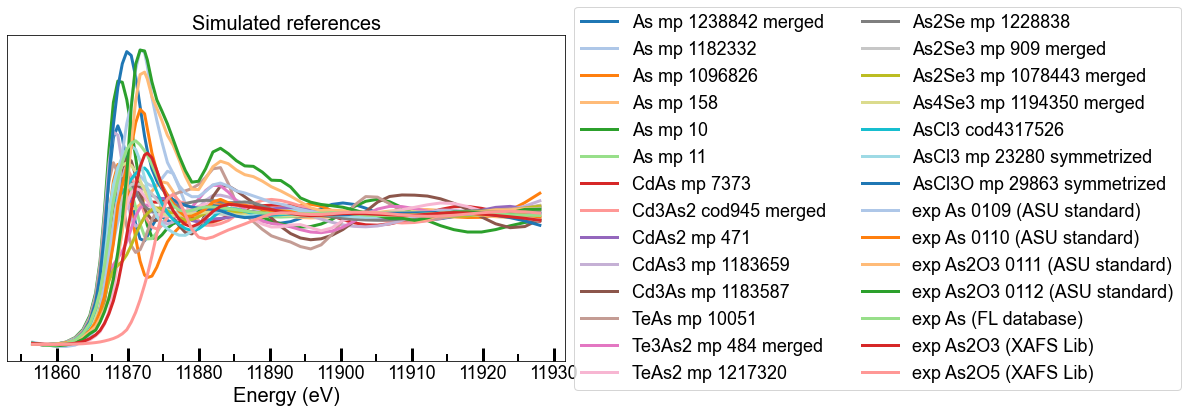

In [217]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, ref in enumerate(Refs):
    if i >= 20:
        c = i - 20
    else:
        c = i
    ax.plot(Energy, ref, '-', linewidth=3, c=plt.cm.tab20(c/19), label=data_columns[i], alpha=1.)
ax.legend(fontsize=18, loc='center left', bbox_to_anchor=(1., .5), ncol=2)
plt.title("Simulated references", fontsize=20)
format_axis(ax)
plt.show()

# PCA Analysis

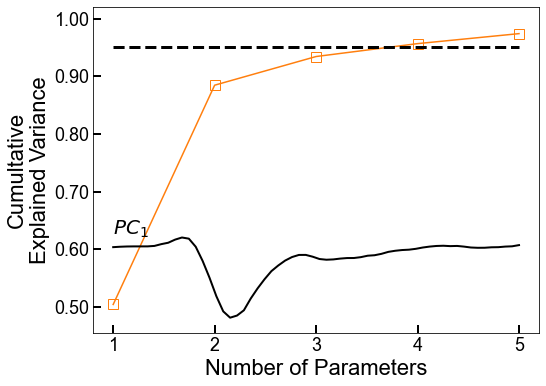

In [191]:
make_scree_plot(Refs)    

# Generate dataset using linear combinations of reference spectra

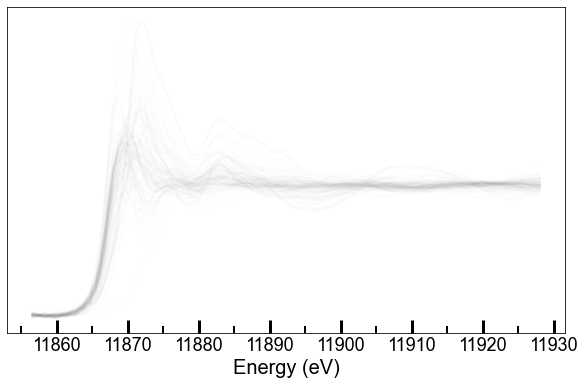

In [259]:
kwargs = {'N': 100, 'scale': 0.01, 'dropout': 0.9, 'training': False}
data, coeffs = generate_linear_combos(Refs, **kwargs)
kwargs = {'N': 100, 'scale': 0.01, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)

plot_spectra(Energy, data, mod=0)

In [260]:
utils = reload(utils)
from utils import *

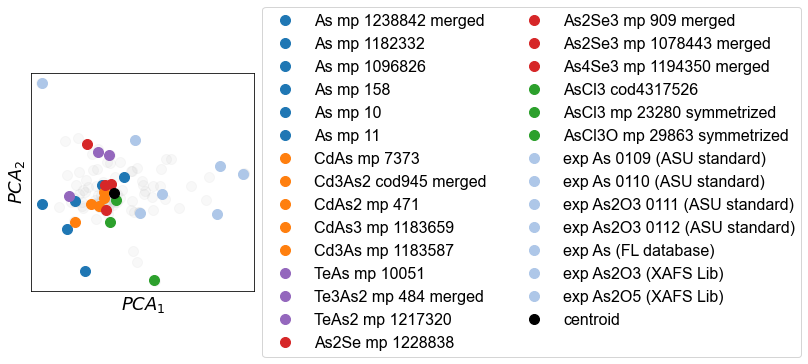

In [261]:
two_dimensional_visualization(data, Refs, data_columns, ncol=2, method='PCA')

# Augment dataset using a GAN

In [20]:
mlmodels = reload(mlmodels)

In [21]:
latent_dim = 15
wgan = mlmodels.WGAN(Refs, latent_dim)
# args = [Refs, latent_dim]
# wgan = mlmodels.WGAN_GP(10, *args)

kwargs = {'N': 5, 'scale': 0.0, 'dropout': 0.1 , 'training': False}
real_data, real_coeffs = generate_linear_combos(Refs, **kwargs)
fake_data, fake_coeffs = wgan.generate_fake_samples(6, training=False)

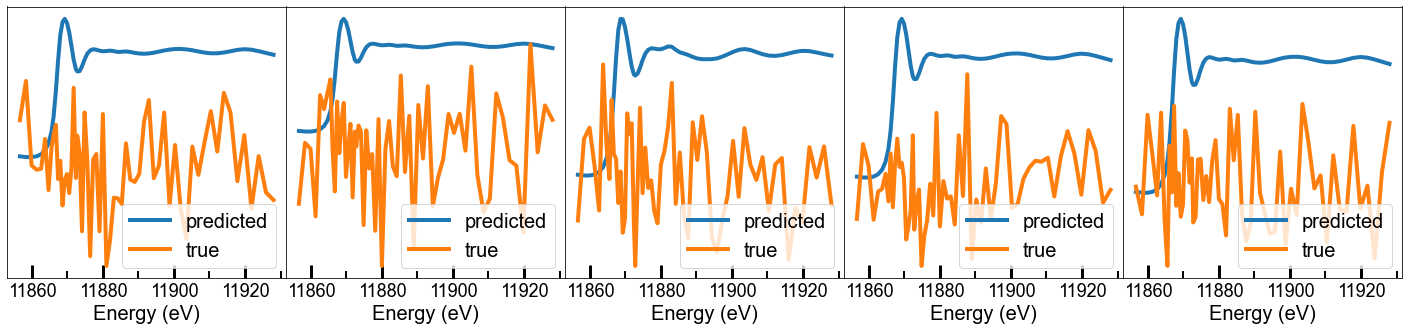

mean absolute error: 0.8350902817130869


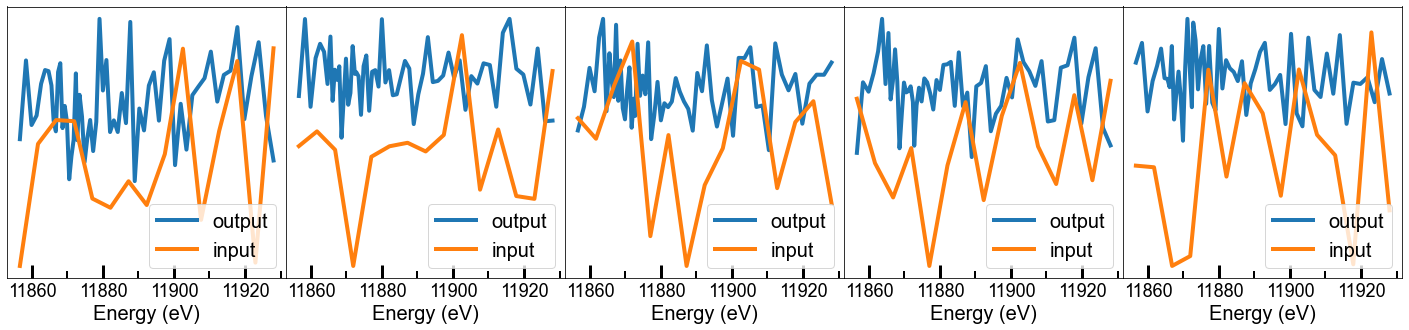

In [22]:
plot_reconstructions(fake_data, fake_coeffs, 5, Energy, Refs)
wgan.plot_input_output(5, Energy, Refs)

Discriminator Loss is the main convergence metric for GANs. Possible improvement is adding a gradient penalty to implement a WGAN-GP. Discriminator loss is the (negative) approximation of the Wasserstein distance so it should converge to zero (can't tell the different between real and fake images).

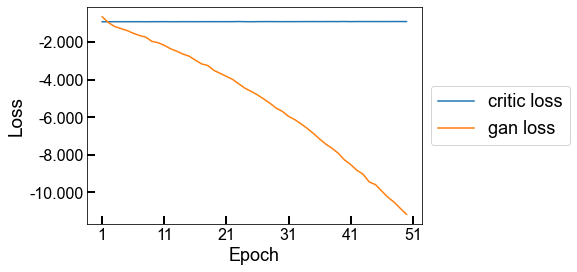

In [23]:
wgan.train(n_epochs=50, n_batch=128)

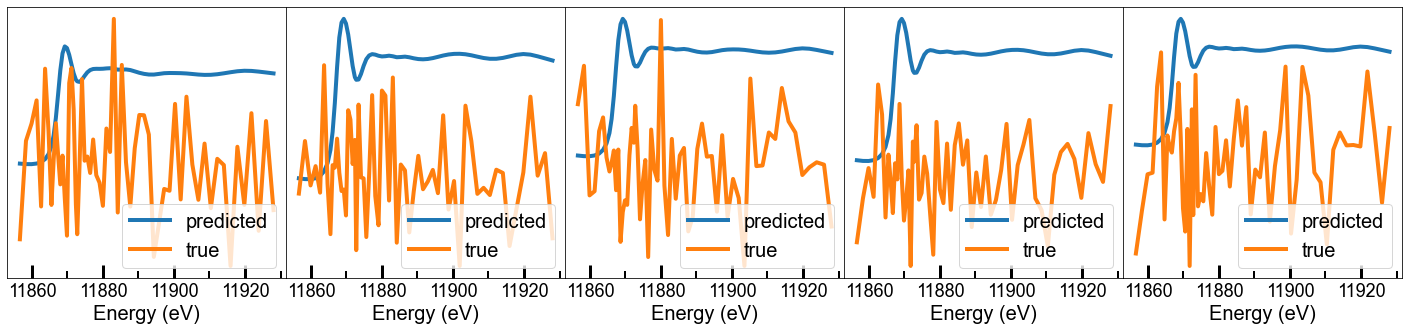

mean absolute error: 1.0437860303118904


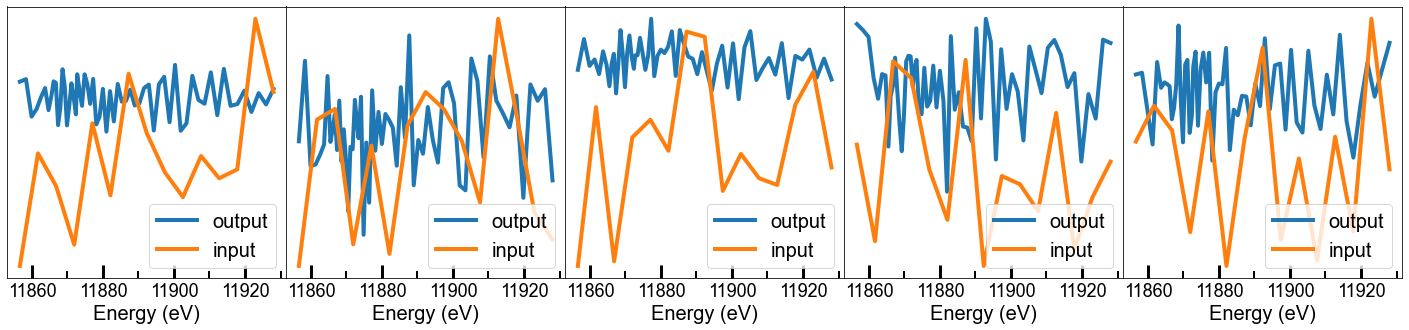

In [24]:
fake_data, fake_coeffs = wgan.generate_fake_samples(5, training=False)
noise = wgan._generate_latent_points(5)
plot_reconstructions(fake_data, fake_coeffs, 5, Energy, Refs)
wgan.plot_input_output(5, Energy, Refs)

# Initialize Selector and perform selection algorithm

### Some potential advancements:

1. Logistic regression and xgboost are models with feature importances that will work if the labels were one dimensional. A work around is using a RegressorChain or MultiOutputRegressor wrapper model.

2. Gaussian processes and other nonlinear models would work if permutation_importance worked as the importance_getter

e.g.

` def importance(model):`
    
 &emsp; &emsp; ` return permutation_importance(model, data, coeffs, scoring='neg_mean_squared_error')`
    
` importance_getter = importance`

These features can theoretically be implemented to improve the RFE algorithm.

In [262]:
energy_point_selector = reload(selector.energy_point_selector)
select = energy_point_selector.Selector(data, coeffs)

For a list of possible scoring criteria, see `sklearn.metrics.SCORERS.keys()`

In [264]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest']
n_points = [18]
Scores = []
Epts = []

for npts in n_points:
    print(f'\nNum points: {npts}\n-----------------------')
    scores = []
    epts = []
    for model in models:
        print(f'\n{model}:')
        select = energy_point_selector.Selector(data, coeffs)
        rfe, cvscore = select.select_energy_points(estimator=model, n_points=npts,
                                                   scoring='neg_root_mean_squared_error')
        energy_points = Energy[rfe.support_]
        epts.append(energy_points)
        scores.append(cvscore)
    Scores.append(scores)
    Epts.append(epts)

# Visualize Selected Energy Points

In [ ]:
nrows = len(n_points)
ncols = len(models)
fig, axes = plt.subplots(figsize=(ncols*5, nrows*5), nrows=nrows, ncols=ncols)
plt.subplots_adjust(wspace=0, hspace=0.45)

for i, npts in enumerate(n_points):
    row_axes = axes[i]
    for energy_pts, model, score, ax in zip(Epts[i], models, Scores[i], row_axes):
        diff = 25
        ticks = (10, 20)
        visualize_energy_points((fig, ax), Energy, Refs,
                                energy_pts, ticks=ticks, label=model)
        text = ax.text(np.max(Energy) - diff, np.max(Refs)*0.5, f'RMSE:\n{-score:.3}',
                       ha="left", va="center", size=20)
    label = row_axes[0].set_ylabel(f'n = {npts}', fontsize=20)

# Model Selection

The best model is the linear regression with n = 6 energy points.
We will use the energy points indicating by that model.

In [314]:
kwargs = {'N': 10000, 'scale': 0.01, 'dropout': 0.9, 'training': False}
data, coeffs = generate_linear_combos(Refs, **kwargs)
kwargs = {'N': 50, 'scale': 0.01, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)
select = energy_point_selector.Selector(data, coeffs)

In [303]:
best_estimator = 'Random Forest'
best_n = 10
rfe, cvscore = select.select_energy_points(estimator=best_estimator, n_points=best_n,
                                           scoring='neg_root_mean_squared_error')
energy_measurements = Energy[rfe.support_]
indices = [i for i, e in enumerate(Energy) if e in energy_measurements]

Score: -0.072 (0.002)


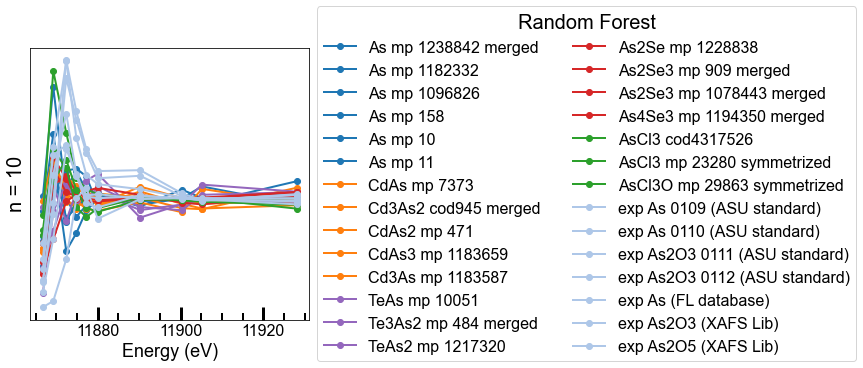

In [304]:
fig, ax = plt.subplots(figsize=(5, 5))

diff = 11.8
diff = -2
ticks = (5, 20)
fontsize = 20

n = Refs.shape[0]
ele_to_idx_map = {'Cd': 2, 'Te': 8, 'Se': 6, 'Cl': 4, 'exp': 1, 'As': 0}
for i, ref in enumerate(Refs[:, indices]):
    label = data_columns[i]
    for key in ele_to_idx_map.keys():
        if key in label:
            j = ele_to_idx_map[key]
            break
    if n < 20:
        c = i
    else:
        c = j
    color = plt.cm.tab20(c)  
    ax.plot(Energy[indices], ref, 'o-', linewidth=2, c=color, label=label)

    format_axis(ax, ticks=ticks, fontsize=fontsize-2)
ax.legend(fontsize=fontsize-4, loc='center left', bbox_to_anchor=(1., .5),
         title=f'{best_estimator}', title_fontsize=fontsize, ncol=2)
label = ax.set_ylabel(f'n = {best_n}', fontsize=20)

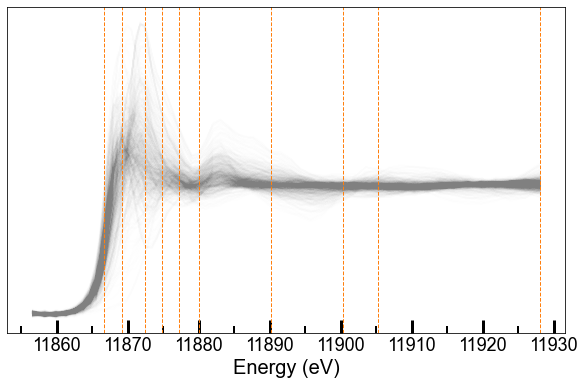

In [305]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, spectrum in enumerate(data):
    ax.plot(Energy, spectrum , '-', linewidth=2, c='gray', alpha=0.005)
format_axis(ax)

for energy in energy_measurements:
    ax.axvline(energy, c=plt.cm.tab20(2), linestyle='--', linewidth=1.)

plt.show()

## Validate Regression Task using energy subset

Train and score each regression model using the selected energy subset to predict the linear combination coefficients.

In [315]:
ref_coeff = np.identity(Refs.shape[0])
m, x, y, z = 'Model', 'Train', 'Validation', 'Refs'
print(f'{m:45s}| {x:20s}| {y:20s}| {z:20s} ')
print('-'*105)
    
for reg in [LinearRegression(), RandomForestRegressor(), DecisionTreeRegressor(),
            GaussianProcessRegressor(), MLPRegressor(hidden_layer_sizes=(40, 40)),
            Lasso()]:
    
    reg.fit(data[:, indices], coeffs)
    
    x = f'{reg.score(data[:, indices], coeffs):.4f}'
    y = f'{reg.score(test_data[:, indices], test_coeffs):.4f}'
    z = f'{reg.score(Refs[:, indices], ref_coeff):.4f}'
    print(f'{str(reg):45s}| {x:20s}| {y:20s}| {z:20s} ')

Model                                        | Train               | Validation          | Refs                 
---------------------------------------------------------------------------------------------------------
LinearRegression()                           | 0.3428              | -0.1874             | 0.3654               
RandomForestRegressor()                      | 0.9711              | 0.6737              | 1.0000               
DecisionTreeRegressor()                      | 1.0000              | 0.0834              | 1.0000               
GaussianProcessRegressor()                   | 0.9003              | 0.6286              | 0.9963               
MLPRegressor(hidden_layer_sizes=(40, 40))    | 0.2977              | -0.0544             | 0.3356               
Lasso()                                      | 0.0000              | -0.1274             | -0.0001              


` The Random Forest Regressor performed the best and subsequent analysis should use this model.`

## Test dataset
Test on experimental data.

In [316]:
kwargs = {'N': 10000, 'scale': 0.01, 'dropout': 0.9, 'training': False}
data, coeffs = generate_linear_combos(Refs, **kwargs)
kwargs = {'N': 100, 'scale': 0.01, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)

In [317]:
reg = RandomForestRegressor()
reg.fit(data[:, indices], coeffs)

y_pred = reg.predict(test_data[:, indices])
print(f'Add to one? {np.sum(y_pred, axis=1).all()}')

for metric in ["mean_squared_error", "explained_variance_score"]:
    test_score = eval(metric)(y_pred, test_coeffs)
    metric = metric.replace('_', ' ')
    print(f'{metric}: {test_score:.5f}')

Add to one? True
mean squared error: 0.00314
explained variance score: 0.34130


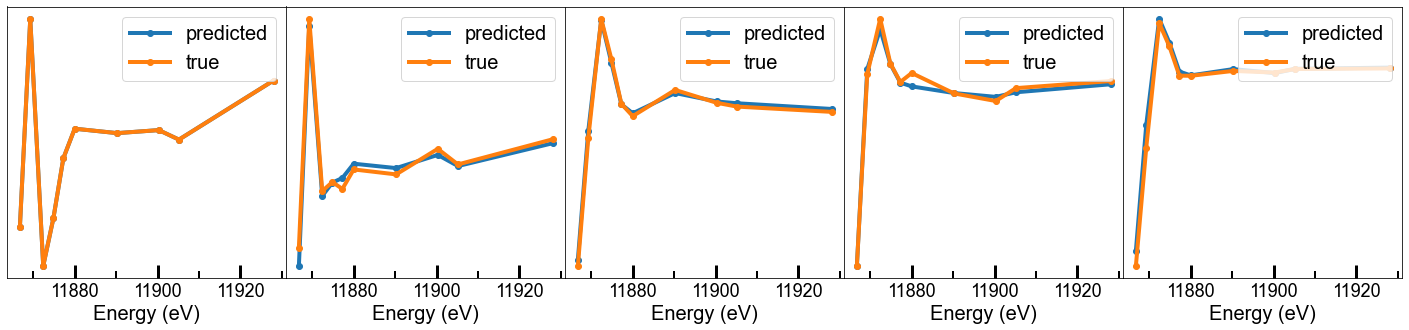

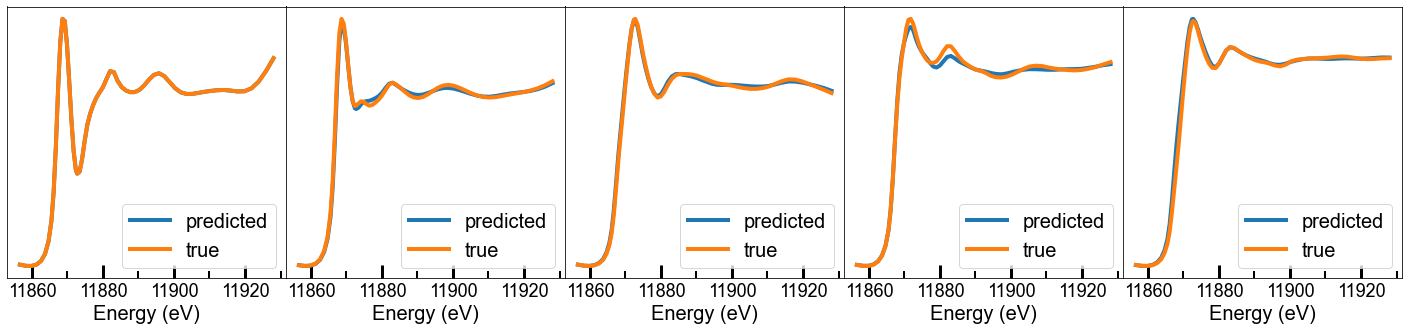

In [318]:
for show_subset in [True, False]:
    
    m = 5
    fig, axes = plt.subplots(figsize=(5*m, 5), ncols=m)
    plt.subplots_adjust(wspace=0)

    for i in range(m):
        pred = Refs.T @ y_pred[i]
        true = Refs.T @ test_coeffs[i]
        ax = axes[i]

        if show_subset:
            ax.plot(Energy[indices], pred[indices], 'o-', linewidth=4, c=plt.cm.tab20(0), label='predicted')
            ax.plot(Energy[indices], true[indices], 'o-', linewidth=4, c=plt.cm.tab20(2), label='true')
            loc = 1
            ticks=(1, 4)
            ticks=(10,20)
        else:
            ax.plot(Energy, pred, '-', linewidth=4, c=plt.cm.tab20(0), label='predicted')
            ax.plot(Energy, true, '-', linewidth=4, c=plt.cm.tab20(2), label='true')
            loc = 4
            ticks=(10, 20)

        format_axis(ax, ticks=ticks, fontsize=20)
        ax.legend(fontsize=20, loc=loc)
    plt.show()

# Compare to Random Energies

In [295]:
kwargs = {'N': 1000, 'scale': 0.01, 'dropout': 0.3, 'training': False}
data, coeffs = generate_linear_combos(Refs, **kwargs)
kwargs = {'N': 10, 'scale': 0.01, 'dropout': 0.3, 'training': False}
test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)
select = energy_point_selector.Selector(data, coeffs)

In [296]:
baseline = []
metric = 'explained_variance_score'
for i, d in enumerate(data):
    c = coeffs[i]
    p = Refs.T @ c
    p = p - np.min(p)
    score = eval(metric)(d, p)
    baseline.append(score)
baseline = np.array(baseline)
mu = np.average(baseline)
sig2 = np.std(baseline)
print(f'{mu} +/- {sig2}')

0.9992541283350156 +/- 0.00014420572906770416


In [297]:
metrics = []
ns = np.arange(4, 27, 2)
for best_n in ns:
    for mode in ['RFE', 'random']:
        if mode == 'RFE':
            rfe, cvscore = select.select_energy_points(estimator='randomforest', n_points=best_n,
                                                       scoring='neg_root_mean_squared_error', verbose=False)
            energy_measurements = Energy[rfe.support_]
            indices = [i for i, e in enumerate(Energy) if e in energy_measurements]
        else:
            indices = np.random.randint(0, high=len(Energy), size=(best_n,))
        
        reg = RandomForestRegressor()
        reg.fit(data[:, indices], coeffs)
        
        pred_coeff = reg.predict(test_data[:, indices])
        
        cv_scores = []
        m = 10
        for i in range(m):
            pred_spectra = Refs.T @ pred_coeff[i]
            pred_spectra = pred_spectra - np.min(pred_spectra)
            true_spectra = test_data[i]
        
            temp_score = eval(metric)(pred_spectra, true_spectra)
            cv_scores.append(temp_score)
        score = np.average(cv_scores)  
#         print(f'{mode}: n = {best_n}: score = {score}')
        metrics.append(score)
metrics = np.array(metrics).reshape(-1, 2)

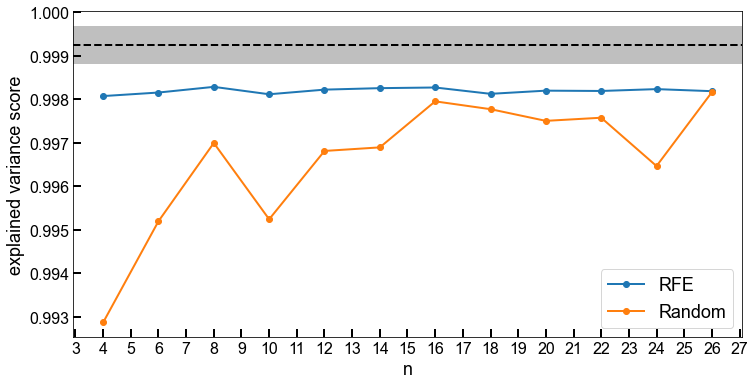

In [298]:
x = np.array(ns, dtype=int)
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(x, metrics[:, 0], 'o-', linewidth=2, label='RFE')
plt.plot(x, metrics[:, 1], 'o-', linewidth=2, label='Random')

ax.axhline(y=mu, c='k', linestyle='--', linewidth=2.)
xlim = ax.get_xlim()
fill = np.linspace(xlim[0], xlim[1], 2)
plt.fill_between(fill, mu - 3*sig2, y2=mu + 3*sig2, fc='gray', alpha=0.5)
plt.xlim(xlim)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_yticklabels(np.array(ax.get_yticks(), dtype=float), fontsize=16)
ax.set_xticklabels(np.array(ax.get_xticks(), dtype=int), fontsize=16)
ax.set_xlabel('n', fontsize=18)
metric = metric.replace('_', ' ')
ax.set_ylabel(f'{metric}', fontsize=18)
ax.tick_params(direction='in', width=2, length=8, which='major')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.legend(fontsize=18)
plt.show()